In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
installments_payments = help_tool.csv_download(r'Archive\home-credit-default-risk\installments_payments.csv')
help_tool.first_look(installments_payments)

Dataset has 13605401 observations and 8 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_PREV,int64,0,0.0
SK_ID_CURR,int64,0,0.0
NUM_INSTALMENT_VERSION,float64,0,0.0
NUM_INSTALMENT_NUMBER,int64,0,0.0
DAYS_INSTALMENT,float64,0,0.0
DAYS_ENTRY_PAYMENT,float64,2905,0.0
AMT_INSTALMENT,float64,0,0.0
AMT_PAYMENT,float64,2905,0.0


Null values

In [39]:
installments_payments[installments_payments['DAYS_ENTRY_PAYMENT'].isnull() & installments_payments['AMT_PAYMENT'].notna()]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT


In [40]:
null_ids  = installments_payments[installments_payments['DAYS_ENTRY_PAYMENT'].isnull()]['SK_ID_CURR'].drop_duplicates().to_list()

In [41]:
installments_payments[installments_payments['SK_ID_CURR'].isin(null_ids)]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
306,2745338,121231,0.0,22,-1753.0,-1742.0,6750.000,6750.000
347,2137863,121809,1.0,2,-604.0,-607.0,44964.000,44964.000
454,1376802,104523,0.0,13,-387.0,-387.0,0.225,0.225
768,1007398,186856,0.0,33,-1882.0,-1899.0,5625.000,5625.000
927,1682768,143109,1.0,4,-715.0,-721.0,39604.500,39604.500
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


In [42]:
installments_payments[installments_payments['SK_ID_CURR'].isin(null_ids) & installments_payments['DAYS_ENTRY_PAYMENT'].isna()]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
3764207,1531600,103793,1.0,7,-668.0,NaN,49741.020,NaN
3764208,1947105,159974,1.0,24,-36.0,NaN,22849.515,NaN
3764209,1843773,167270,1.0,22,-20.0,NaN,48092.355,NaN
3764210,1691592,192536,1.0,5,-2561.0,NaN,7675.425,NaN
3764211,1531299,157088,0.0,11,-1847.0,NaN,67.500,NaN
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


In [43]:
installments_payments[(installments_payments['SK_ID_CURR'] == 121231) & (installments_payments['SK_ID_PREV'] == 2745338)].sort_values(by='NUM_INSTALMENT_NUMBER')

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
1360627,2745338,121231,0.0,1,-2393.0,-2400.0,6750.000,6750.000
2398622,2745338,121231,0.0,2,-2363.0,-2376.0,6750.000,6750.000
466052,2745338,121231,0.0,3,-2332.0,-2340.0,6750.000,6750.000
2705463,2745338,121231,0.0,4,-2302.0,-2306.0,6750.000,6750.000
515636,2745338,121231,0.0,5,-2271.0,-2280.0,6750.000,6750.000
3109432,2745338,121231,0.0,6,-2240.0,-2250.0,6750.000,6750.000
1395020,2745338,121231,0.0,7,-2210.0,-2216.0,6750.000,6750.000
720020,2745338,121231,0.0,8,-2179.0,-2183.0,6750.000,6750.000
886897,2745338,121231,0.0,9,-2149.0,-2158.0,6750.000,6750.000
3300160,2745338,121231,0.0,10,-2118.0,-2123.0,6750.000,6750.000


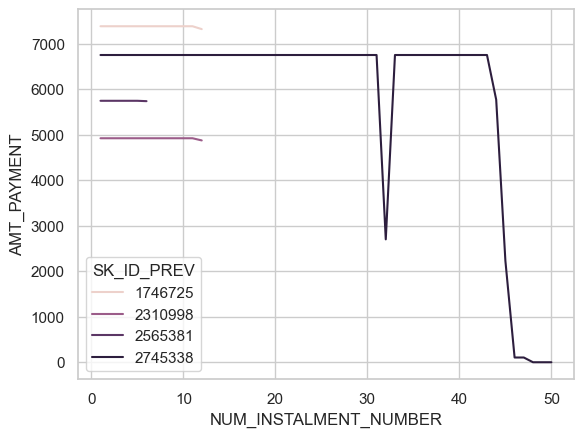

In [44]:
sns.lineplot(installments_payments[installments_payments['SK_ID_CURR'] == 121231].groupby(['NUM_INSTALMENT_NUMBER', 'SK_ID_PREV'])['AMT_PAYMENT'].sum().to_frame().reset_index(), y='AMT_PAYMENT', x='NUM_INSTALMENT_NUMBER', hue='SK_ID_PREV')
plt.show()

dropping all null values as it's not bringing information on customer loan status

In [45]:
installments_payments = installments_payments[installments_payments['DAYS_ENTRY_PAYMENT'].notna()]

In [46]:
installments_payments.var()

SK_ID_PREV                2.875175e+11
SK_ID_CURR                1.055108e+10
NUM_INSTALMENT_VERSION    1.064370e+00
NUM_INSTALMENT_NUMBER     7.108255e+02
DAYS_INSTALMENT           6.415139e+05
DAYS_ENTRY_PAYMENT        6.409378e+05
AMT_INSTALMENT            2.557190e+09
AMT_PAYMENT               2.996006e+09
dtype: float64

In [47]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


NUM_INSTALMENT_VERSION


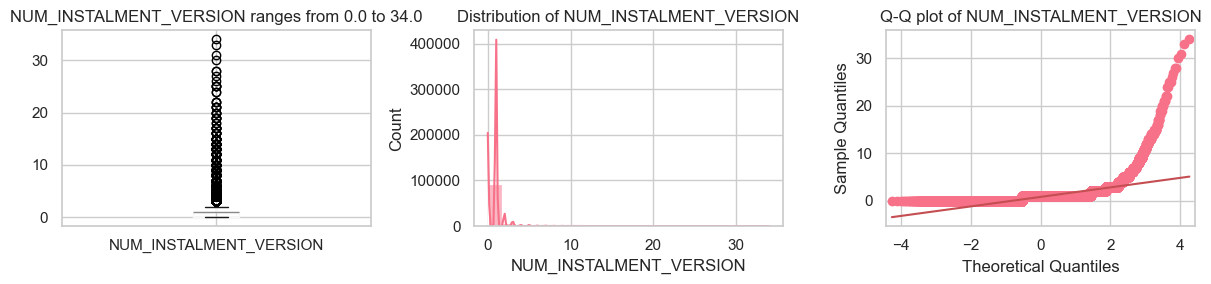

NUM_INSTALMENT_NUMBER


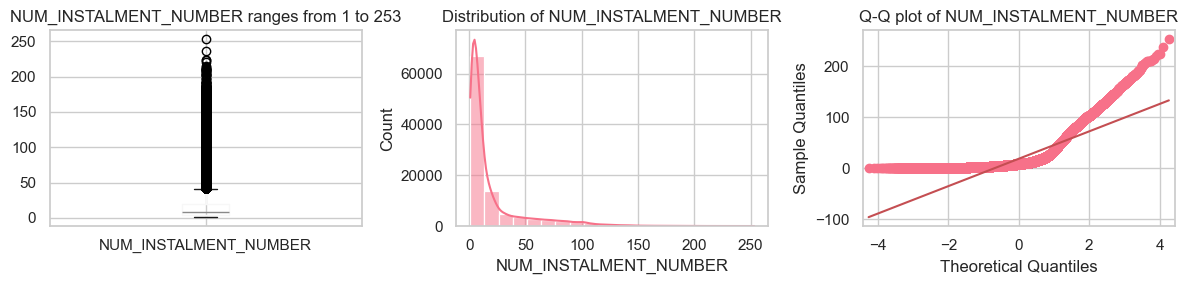

DAYS_INSTALMENT


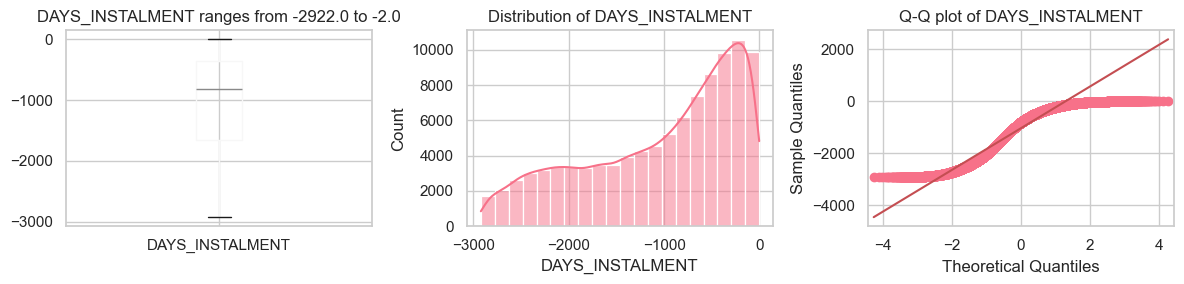

DAYS_ENTRY_PAYMENT


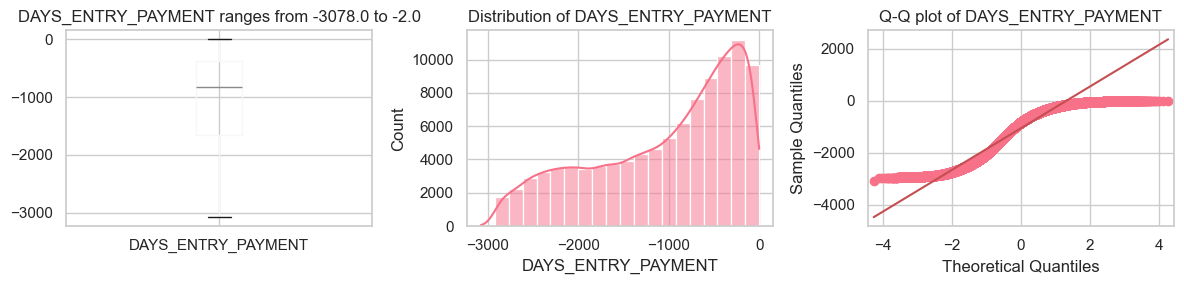

AMT_INSTALMENT


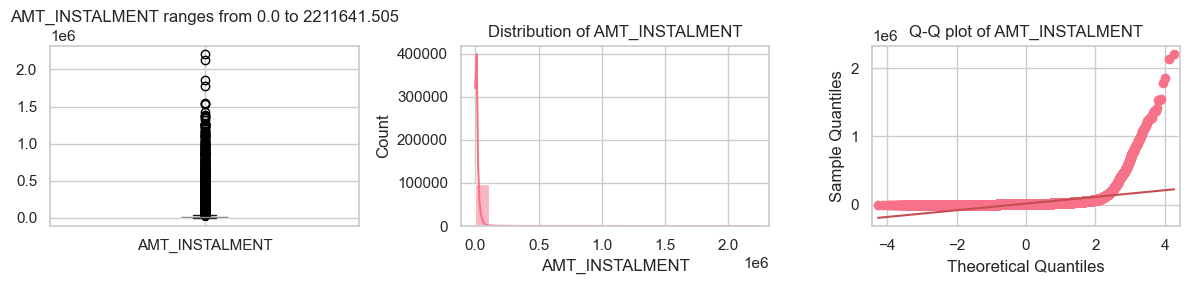

AMT_PAYMENT


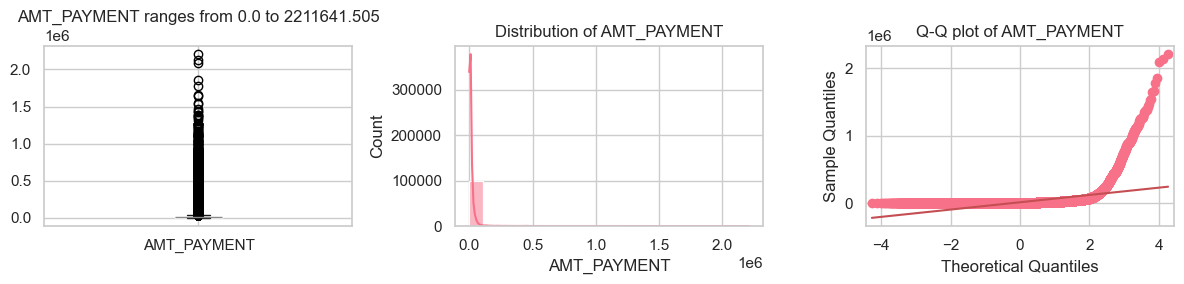

In [42]:
help_visuals.distribution_check(installments_payments.drop(columns=['SK_ID_PREV', 'SK_ID_CURR']).sample(100000, random_state=42))

In [43]:
installments_payments[installments_payments['SK_ID_CURR'] == 193053]#['NUM_INSTALMENT_VERSION']

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
181872,2085231,193053,3.0,1,-44.0,-21.0,631.035,631.035
2236835,2085231,193053,3.0,2,-14.0,-21.0,8393.175,8393.175


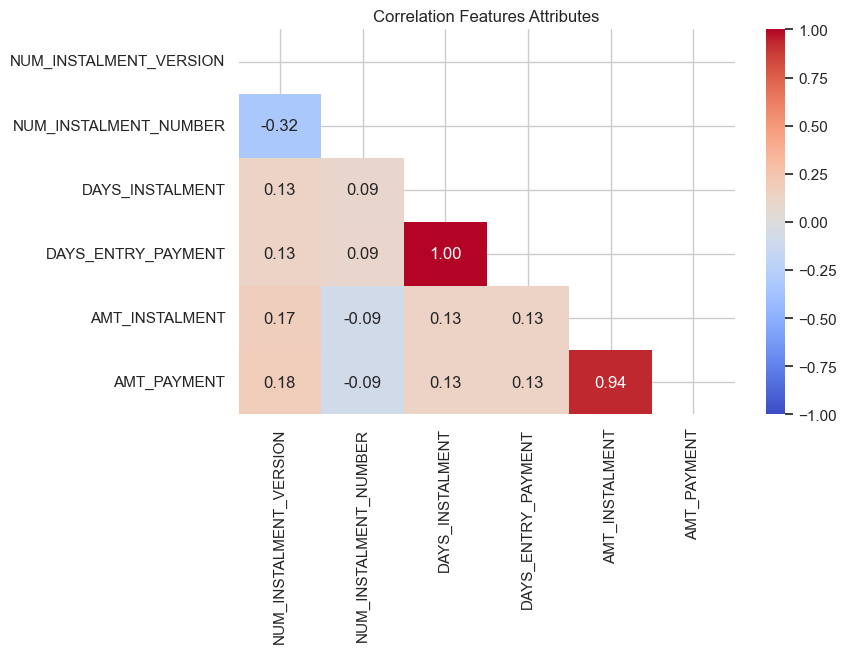

In [48]:
help_visuals.heatmap(installments_payments.drop(columns=['SK_ID_PREV', 'SK_ID_CURR']), 'Features', 'pearson')

Bad data entry?

In [45]:
installments_payments[(installments_payments['SK_ID_CURR'] == 423205) & (installments_payments['SK_ID_PREV'] == 1463622)].sort_values(by='NUM_INSTALMENT_NUMBER')

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
12624134,1463622,423205,1.0,1,-467.0,-477.0,19680.885,19680.885
13155908,1463622,423205,1.0,2,-437.0,-447.0,19680.885,19680.885
12294870,1463622,423205,1.0,3,-407.0,-418.0,19680.885,19680.885
13423193,1463622,423205,1.0,4,-377.0,-387.0,19680.885,19680.885
13122255,1463622,423205,1.0,5,-347.0,-362.0,19680.885,19680.885
13315627,1463622,423205,1.0,6,-317.0,-317.0,19680.885,213673.365
13315628,1463622,423205,2.0,6,-317.0,-317.0,193992.480,213673.365
12908289,1463622,423205,3.0,7,-287.0,-296.0,9899.235,9899.235
12593345,1463622,423205,3.0,8,-257.0,-268.0,9899.235,9899.235
13225149,1463622,423205,3.0,9,-227.0,-239.0,9899.235,9899.235


In [46]:
installments_payments[installments_payments.duplicated(subset=['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_NUMBER', 'AMT_PAYMENT']) == True]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
131,1496271,112436,2.0,1,-201.0,-207.0,16387.965,32400.000
182,2428866,180879,8.0,5,-41.0,-46.0,7543.665,36000.000
361,2715881,124670,4.0,4,-564.0,-572.0,41527.575,49500.000
572,1463863,123741,2.0,1,-406.0,-432.0,113977.080,135000.000
689,1673874,172811,2.0,4,-381.0,-399.0,170938.215,226894.275
...,...,...,...,...,...,...,...,...
13604300,1131431,447210,2.0,3,-281.0,-301.0,131702.940,157500.000
13604413,1969286,454959,2.0,3,-831.0,-842.0,33799.365,48032.910
13604739,1640576,453893,21.0,12,-33.0,-34.0,12015.810,22500.000
13604869,1477019,433531,23.0,14,-7.0,-25.0,12708.045,58500.000


In [47]:
installments_payments[(installments_payments['SK_ID_CURR'] == 112436) & (installments_payments['SK_ID_PREV'] == 1496271)].sort_values(by='NUM_INSTALMENT_NUMBER')

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
130,1496271,112436,1.0,1,-201.0,-207.0,16012.035,32400.000
131,1496271,112436,2.0,1,-201.0,-207.0,16387.965,32400.000
1469783,1496271,112436,3.0,2,-171.0,-185.0,14883.165,29691.360
1469784,1496271,112436,4.0,2,-171.0,-185.0,14808.195,29691.360
15254,1496271,112436,5.0,3,-141.0,-149.0,13810.005,13810.005
3472266,1496271,112436,6.0,4,-111.0,-120.0,13679.505,13679.505
2138599,1496271,112436,6.0,5,-81.0,-92.0,13679.505,13679.505
773032,1496271,112436,6.0,6,-51.0,-71.0,13679.505,13679.505
1158230,1496271,112436,6.0,7,-21.0,-30.0,13679.505,13679.505


In [48]:
installments_payments.drop(columns='NUM_INSTALMENT_VERSION', inplace=True)

sum of instalments made for 1 month

In [97]:
duckdb.query("""
             SELECT 
                SK_ID_CURR, SK_ID_PREV, 
                CASE WHEN MISSED_MONTHS <= 0 THEN 0 ELSE MISSED_MONTHS END AS MISSED_MONTHS
             FROM (
                SELECT 
                    SK_ID_CURR, SK_ID_PREV,
                    ROUND((DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT) / 30, 0) AS MISSED_MONTHS
                FROM installments_payments A
                WHERE SK_ID_PREV = 2745338 AND SK_ID_CURR = 121231 
             ) A

""")

┌────────────┬────────────┬───────────────┐
│ SK_ID_CURR │ SK_ID_PREV │ MISSED_MONTHS │
│   int64    │   int64    │    double     │
├────────────┼────────────┼───────────────┤
│     121231 │    2745338 │           0.0 │
│     121231 │    2745338 │           0.0 │
│     121231 │    2745338 │           0.0 │
│     121231 │    2745338 │           0.0 │
│     121231 │    2745338 │           0.0 │
│     121231 │    2745338 │           1.0 │
│     121231 │    2745338 │           0.0 │
│     121231 │    2745338 │           0.0 │
│     121231 │    2745338 │           0.0 │
│     121231 │    2745338 │           0.0 │
│        ·   │       ·    │            ·  │
│        ·   │       ·    │            ·  │
│        ·   │       ·    │            ·  │
│     121231 │    2745338 │           0.0 │
│     121231 │    2745338 │           0.0 │
│     121231 │    2745338 │           0.0 │
│     121231 │    2745338 │           1.0 │
│     121231 │    2745338 │           0.0 │
│     121231 │    2745338 │     

In [105]:
installments_payments_overall = duckdb.query("""
             WITH 

             instalments AS (
             SELECT 
                SK_ID_CURR, SK_ID_PREV, 
                SUM(AMT_INSTALMENT) AS AMT_INSTALMENT, 
                COUNT(NUM_INSTALMENT_NUMBER) AS INSTALMENT_COUNT
             FROM (
                SELECT DISTINCT 
                    SK_ID_CURR, SK_ID_PREV, AMT_INSTALMENT, NUM_INSTALMENT_NUMBER
                FROM installments_payments
                ) A
             GROUP BY SK_ID_CURR, SK_ID_PREV
             )

             ,payments AS (
             SELECT 
                SK_ID_CURR, SK_ID_PREV,
                SUM(AMT_PAYMENT) AS AMT_PAYMENT, 
             FROM installments_payments
             GROUP BY SK_ID_CURR, SK_ID_PREV
             )

             ,missed_months AS (
             SELECT SK_ID_CURR, SK_ID_PREV, MAX(MISSED_MONTHS) AS MAX_MISSED_MONTHS, SUM(MISSED_MONTHS) AS SUM_MISSED_MONTHS
             FROM (
               SELECT 
                  SK_ID_CURR, SK_ID_PREV, 
                  CASE WHEN MISSED_MONTHS <= 0 THEN 0 ELSE MISSED_MONTHS END AS MISSED_MONTHS
               FROM (
                  SELECT 
                     SK_ID_CURR, SK_ID_PREV,
                     ROUND((DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT) / 30, 0) AS MISSED_MONTHS
                  FROM installments_payments A
               ) A
             ) A
             GROUP BY SK_ID_CURR, SK_ID_PREV
             )

             SELECT 
                A.SK_ID_PREV, A.SK_ID_CURR, 
                ROUND(A.AMT_INSTALMENT - B.AMT_PAYMENT, 2) AS MONEY_NOT_PAYED,
                A.INSTALMENT_COUNT,
                C.MAX_MISSED_MONTHS, C.SUM_MISSED_MONTHS
             FROM instalments A
             FULL OUTER JOIN payments B 
             ON A.SK_ID_CURR=B.SK_ID_CURR AND A.SK_ID_PREV=B.SK_ID_PREV
             FULL OUTER JOIN missed_months C 
             ON A.SK_ID_CURR=C.SK_ID_CURR AND A.SK_ID_PREV=C.SK_ID_PREV
             --WHERE A.SK_ID_PREV = 2745338 AND A.SK_ID_CURR = 121231 

""").to_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [106]:
installments_payments_overall.head()

,SK_ID_PREV,SK_ID_CURR,MONEY_NOT_PAYED,INSTALMENT_COUNT,MAX_MISSED_MONTHS,SUM_MISSED_MONTHS
0,1082987,110380,0.0,24,1.0,3.0
1,1322796,148250,0.0,14,1.0,1.0
2,2426216,143762,0.0,159,1.0,50.0
3,1968531,135887,0.0,111,1.0,10.0
4,2787992,131040,0.0,10,1.0,1.0


Days_Missed


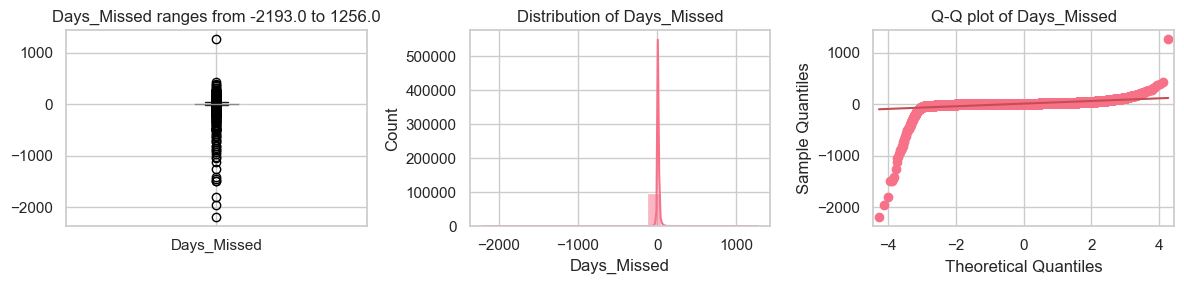

AMT_Missed


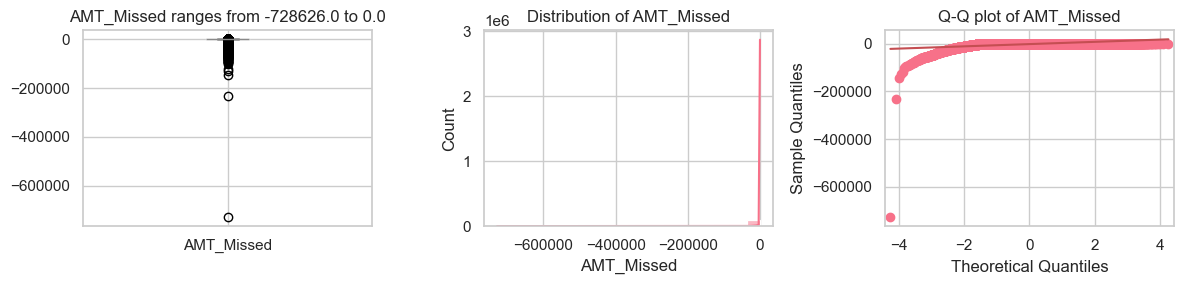

In [57]:
help_visuals.distribution_check(installments_payments[['Days_Missed', 'AMT_Missed']].sample(100000, random_state=42))